# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/CS444/assignment3/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/MyDrive/CS444/assignment3


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from PIL import Image
import torchvision.transforms.functional as TF

def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    elif rot==1:
      return TF.rotate(img, 90)
    elif rot==2:
      return TF.rotate(img, 180)
    elif rot==3:
      return TF.rotate(img, 270)    
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

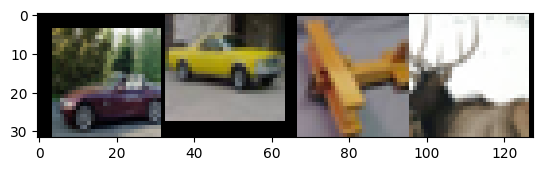

Class labels:  car   car   plane deer 


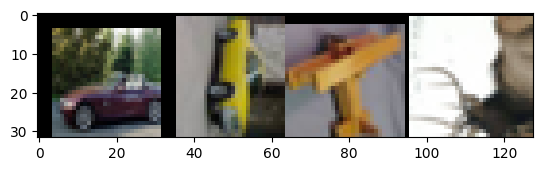

Rotation labels:  0     270   270   90   


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img) #Whitening the input image,it reduces the effect of variations in brightness and contrast between images.
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img) #rescaling the pixel values back to their original range of [0, 255]
    #These values correspond to the mean and standard deviation of the CIFAR-10 dataset, and are used to 
    #normalize the pixel values so that they have a mean of 0 and a standard deviation of 1.
    npimg = img.numpy() #converts the image tensor to a NumPy array 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #transposes the dimensions so that the image is in the format (height, width, channels) instead of the PyTorch format (channels, height, width)
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)
#

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs=net(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels                      
            if task=="rotation":
              imgs=imgs_rotated.to(device)
              labels=rotation_label.to(device)
            elif task=='classification':
              imgs=imgs.to(device)  
              labels=cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs=net(imgs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            _,predicted = torch.max(outputs.data,1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net,testloader,criterion,task)
        


    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), 'my_model.pt')

[1,   100] loss: 1.058 acc: 54.22 time: 8.80
[1,   200] loss: 1.043 acc: 55.50 time: 10.20
[1,   300] loss: 1.014 acc: 56.45 time: 10.33
TESTING:
Accuracy of the network on the 10000 test images: 58.24 %
Average loss on the 10000 test images: 0.980
[2,   100] loss: 0.986 acc: 58.51 time: 9.10
[2,   200] loss: 0.972 acc: 59.05 time: 10.06
[2,   300] loss: 0.976 acc: 59.53 time: 10.50
TESTING:
Accuracy of the network on the 10000 test images: 58.24 %
Average loss on the 10000 test images: 1.011
[3,   100] loss: 0.958 acc: 59.74 time: 9.17
[3,   200] loss: 0.938 acc: 60.61 time: 10.21
[3,   300] loss: 0.934 acc: 61.07 time: 10.37
TESTING:
Accuracy of the network on the 10000 test images: 62.58 %
Average loss on the 10000 test images: 0.896
[4,   100] loss: 0.924 acc: 61.58 time: 8.95
[4,   200] loss: 0.900 acc: 62.06 time: 10.27
[4,   300] loss: 0.896 acc: 62.77 time: 10.20
TESTING:
Accuracy of the network on the 10000 test images: 63.40 %
Average loss on the 10000 test images: 0.885
[5, 

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
model_path = 'my_model.pt'
net = resnet18()
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 4)
net.load_state_dict(torch.load(model_path))
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
# Define the device (GPU or CPU) to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# Freeze all previous layers
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the 'layer4' block and 'fc' layer
for param in net.layer4.parameters():
    param.requires_grad = True
for param in net.fc.parameters():
    param.requires_grad = True

# for name, param in net.named_parameters():
#     if 'layer4' in name or 'fc' in name:  # If the parameter belongs to the 'layer4' block or 'fc' layer
#         param.requires_grad = True  # Set requires_grad to True
#     else:
#         param.requires_grad = False    

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.771 acc: 33.41 time: 11.10
[1,   200] loss: 1.449 acc: 47.12 time: 6.94
[1,   300] loss: 1.392 acc: 49.17 time: 8.58
TESTING:
Accuracy of the network on the 10000 test images: 52.57 %
Average loss on the 10000 test images: 1.320
[2,   100] loss: 1.331 acc: 51.44 time: 8.28
[2,   200] loss: 1.312 acc: 51.98 time: 8.40
[2,   300] loss: 1.334 acc: 51.93 time: 8.29
TESTING:
Accuracy of the network on the 10000 test images: 53.71 %
Average loss on the 10000 test images: 1.276
[3,   100] loss: 1.292 acc: 52.86 time: 8.82
[3,   200] loss: 1.293 acc: 53.69 time: 8.17
[3,   300] loss: 1.275 acc: 53.34 time: 7.65
TESTING:
Accuracy of the network on the 10000 test images: 54.80 %
Average loss on the 10000 test images: 1.248
[4,   100] loss: 1.253 acc: 54.20 time: 8.11
[4,   200] loss: 1.250 acc: 54.30 time: 8.02
[4,   300] loss: 1.255 acc: 54.27 time: 8.50
TESTING:
Accuracy of the network on the 10000 test images: 56.67 %
Average loss on the 10000 test images: 1.213
[5,   100] 

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes)
net.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(filter(lambda p: p.requires_grad, net.parameters()),lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.275 acc: 24.27 time: 8.86
[1,   200] loss: 1.976 acc: 29.36 time: 9.30
[1,   300] loss: 1.895 acc: 31.57 time: 9.37
TESTING:
Accuracy of the network on the 10000 test images: 35.71 %
Average loss on the 10000 test images: 1.765
[2,   100] loss: 1.837 acc: 33.45 time: 8.82
[2,   200] loss: 1.820 acc: 34.26 time: 9.59
[2,   300] loss: 1.792 acc: 34.98 time: 12.13
TESTING:
Accuracy of the network on the 10000 test images: 38.65 %
Average loss on the 10000 test images: 1.704
[3,   100] loss: 1.790 acc: 35.38 time: 8.95
[3,   200] loss: 1.757 acc: 35.97 time: 9.72
[3,   300] loss: 1.774 acc: 36.08 time: 7.53
TESTING:
Accuracy of the network on the 10000 test images: 38.62 %
Average loss on the 10000 test images: 1.688
[4,   100] loss: 1.753 acc: 36.48 time: 10.07
[4,   200] loss: 1.752 acc: 36.67 time: 9.18
[4,   300] loss: 1.736 acc: 36.49 time: 9.14
TESTING:
Accuracy of the network on the 10000 test images: 39.85 %
Average loss on the 10000 test images: 1.667
[5,   100]

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
model_path = 'my_model.pt'
net = resnet18()
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 4)
net.load_state_dict(torch.load(model_path))
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.447 acc: 46.90 time: 10.91
[1,   200] loss: 1.133 acc: 59.85 time: 8.02
[1,   300] loss: 1.037 acc: 63.55 time: 9.68
TESTING:
Accuracy of the network on the 10000 test images: 67.71 %
Average loss on the 10000 test images: 0.922
[2,   100] loss: 0.916 acc: 67.97 time: 8.63
[2,   200] loss: 0.913 acc: 67.68 time: 9.52
[2,   300] loss: 0.879 acc: 69.29 time: 9.53
TESTING:
Accuracy of the network on the 10000 test images: 72.24 %
Average loss on the 10000 test images: 0.799
[3,   100] loss: 0.797 acc: 72.19 time: 8.11
[3,   200] loss: 0.790 acc: 72.26 time: 9.71
[3,   300] loss: 0.792 acc: 72.42 time: 9.80
TESTING:
Accuracy of the network on the 10000 test images: 72.80 %
Average loss on the 10000 test images: 0.794
[4,   100] loss: 0.748 acc: 73.93 time: 8.09
[4,   200] loss: 0.736 acc: 74.45 time: 9.68
[4,   300] loss: 0.713 acc: 75.41 time: 8.93
TESTING:
Accuracy of the network on the 10000 test images: 74.20 %
Average loss on the 10000 test images: 0.758
[5,   100] 

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
num_classes = 10
net.fc = nn.Linear(net.fc.in_features, num_classes)
net.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.218 acc: 22.89 time: 9.72
[1,   200] loss: 1.822 acc: 33.14 time: 9.44
[1,   300] loss: 1.693 acc: 38.02 time: 7.88
TESTING:
Accuracy of the network on the 10000 test images: 45.71 %
Average loss on the 10000 test images: 1.496
[2,   100] loss: 1.518 acc: 44.62 time: 9.82
[2,   200] loss: 1.443 acc: 47.85 time: 8.09
[2,   300] loss: 1.352 acc: 51.12 time: 9.88
TESTING:
Accuracy of the network on the 10000 test images: 54.85 %
Average loss on the 10000 test images: 1.278
[3,   100] loss: 1.246 acc: 54.81 time: 8.97
[3,   200] loss: 1.210 acc: 56.23 time: 8.73
[3,   300] loss: 1.163 acc: 58.58 time: 9.49
TESTING:
Accuracy of the network on the 10000 test images: 60.91 %
Average loss on the 10000 test images: 1.102
[4,   100] loss: 1.096 acc: 60.80 time: 8.21
[4,   200] loss: 1.064 acc: 61.85 time: 9.65
[4,   300] loss: 1.082 acc: 61.95 time: 9.55
TESTING:
Accuracy of the network on the 10000 test images: 63.93 %
Average loss on the 10000 test images: 1.036
[5,   100] l